# Assignment 9

In this project, I developed a **sentiment analysis model** to predict the **sentiment** of movie reviews from an **IMDB dataset**, enabling the classification of reviews as either positive or negative. Leveraging **deep learning** and **natural language processing (NLP)**, the model takes in **tokenized text** (where each review is represented as a sequence of integers corresponding to words) and outputs the probability that the review is positive (label **1**) or negative (label **0**). By training the model on 50,000 labeled movie reviews, the project demonstrates how machine learning can be applied to **automatically analyze audience feedback**, making it possible to quickly gauge sentiment at scale. This approach has broad applications in areas such as **market research**, **brand analysis**, and **content recommendation systems**, allowing businesses to efficiently assess public opinion and tailor strategies based on customer sentiment.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots

import tensorflow as tf
from tensorflow.keras.datasets import imdb

In [ ]:
# read data
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train.shape: (25000,)
Y_train.shape: (25000,)
X_test.shape: (25000,)
Y_test.shape: (25000,)


---
### Data Preprocessing

In [ ]:
print('First training example data:', X_train[0])
print('First training example label:', Y_train[0])

First training example data: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
First t

In [ ]:
# The imdb dataset comes with an index mapping words to integers.
# In the index the words are ordered by frequency they occur.
index = imdb.get_word_index()

# Because we used index_from=3 (above), setting aside ids below 3 for special
# symbols, we need to add 3 to the index values.
index = dict([(key, value+3) for (key, value) in index.items()])

# Create a reverse index so we can lookup tokens assigned to each id.
reverse_index = dict([(value, key) for (key, value) in index.items()])
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'

max_id = max(reverse_index.keys())
print('Largest ID:', max_id)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Largest ID: 88587


In [ ]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [reverse_index.get(i, "#") for i in token_ids]

  # Connect the string tokens with a space.
  return ' '.join(tokens)

# Show the ids corresponding tokens in the first example.
print(X_train[0])
print(decode(X_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
<START> this film was just brilliant

---
### Exploratory Data Analysis (EDA)

### <span style="color:blue">Text Lengths</span>

In [ ]:
rev_len = [len(review) for review in X_train]

train_data_df = pd.DataFrame({'Review_Length': rev_len,
                              'Sentiment': Y_train})

In [ ]:
# Minimum maximum and mean length of positive & negative reviews
len_by_sentiment = train_data_df.groupby('Sentiment')['Review_Length'].describe()
len_by_sentiment = len_by_sentiment[['min', 'max', 'mean']]
print(f'Below are the min, max, and mean of positive and negative reviews where negative reviews are Sentiment = 0 and positive reviews are Sentiment = 1 \n{len_by_sentiment}')

Below are the min, max, and mean of positive and negative reviews where negative reviews are Sentiment = 0 and positive reviews are Sentiment = 1 
            min     max       mean
Sentiment                         
0          11.0  1571.0  235.86432
1          13.0  2494.0  241.56296


In [ ]:
# Separate training data based on positive or negative
neg_rev_train = train_data_df[train_data_df['Sentiment'] == 0]
pos_rev_train = train_data_df[train_data_df['Sentiment']== 1]

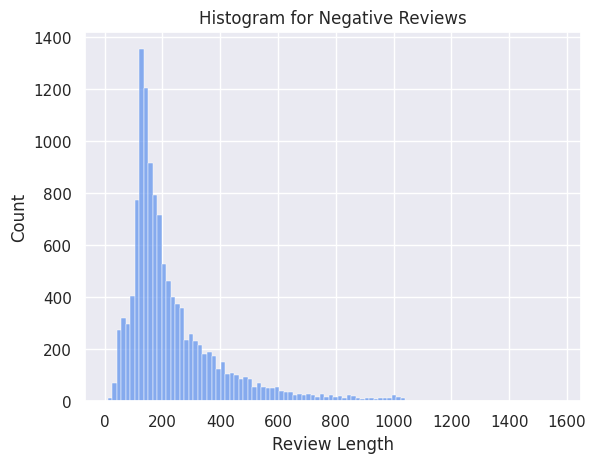

In [ ]:
# Create a histogram of distribution of negative review lengths
sns.histplot(neg_rev_train, x = 'Review_Length', color = 'cornflowerblue', kde = False, bins = 100)
plt.title('Histogram for Negative Reviews')
plt.xlabel('Review Length')
plt.ylabel('Count')

plt.show()

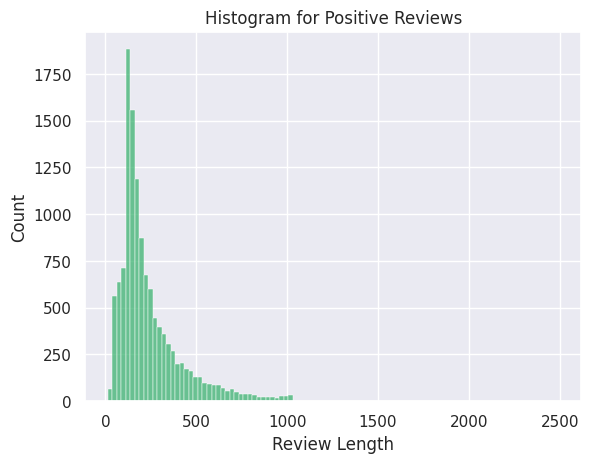

In [ ]:
# Create a histogram of distribution of positive review lengths
sns.histplot(pos_rev_train, x = 'Review_Length', color = 'mediumseagreen', kde = False, bins = 100)
plt.title('Histogram for Positive Reviews')
plt.xlabel('Review Length')
plt.ylabel('Count')

plt.show()

### <span style="color:chocolate">Token Counts</span>

In [ ]:
tokens = ['good', 'bad', 'amazing', 'boring', 'laugh', 'cry']

print(f'The index for good is: {index.get("good")}')
print(f'The index for bad is: {index.get("bad")}')
print(f'The index for amazing is: {index.get("amazing")}')
print(f'The index for boring is: {index.get("boring")}')
print(f'The index for laugh is: {index.get("laugh")}')
print(f'The index for cry is: {index.get("cry")}')

The index for good is: 52
The index for bad is: 78
The index for amazing is: 480
The index for boring is: 357
The index for laugh is: 462
The index for cry is: 1415


In [ ]:
# Create a df with the full review data
train_data_df_full = pd.DataFrame({'Review': X_train,
                              'Sentiment': Y_train})

pos_rev_train_full = X_train[Y_train == 1]
neg_rev_train_full = X_train[Y_train == 0]

In [ ]:
# Encode the tokens
encoded_tokens = [index[token] for token in tokens]

In [ ]:
# Find counts of positive and negative examples that contain each token
token_ct_dict = {}

positives = []
negatives = []

for token in encoded_tokens:
  positive_counts = np.sum([(token in review) for review in pos_rev_train_full])
  negative_counts = np.sum([(token in review) for review in neg_rev_train_full])

  positives.append(positive_counts)
  negatives.append(negative_counts)

token_ct_dict['token'] = tokens
token_ct_dict['positive_counts'] = positives
token_ct_dict['negative_counts'] = negatives

In [ ]:
# Convert dictionary to df for table
token_counts = pd.DataFrame(token_ct_dict)
print(token_counts)

     token  positive_counts  negative_counts
0     good             4767             4849
1      bad             1491             4396
2  amazing              868              240
3   boring              301             1205
4    laugh              525              685
5      cry              231              114


### <span style="color:blue">Reduced Length & Padding</span>

The following restricts the maximum number of tokens by truncating all reviews to a length of 300 and appends special padding tokens (value = 0) to the end of each review until all reviews are of the same length.

In [ ]:
def truncate_pad_data(sequences, max_length):
    # Keras has a convenient utility for padding a sequence:
    # tf.keras.preprocessing.sequence.pad_sequences()
    # Also make sure you get a numpy array rather than an array of lists.
    padded_data = tf.keras.preprocessing.sequence.pad_sequences(sequences,
                                                                maxlen = max_length,
                                                                padding = 'post',
                                                                value = 0)
    return padded_data

# 1+ 2: Truncate and pad the training data
X_train_padded = truncate_pad_data(X_train, max_length=300)

# Check the padded output.
print('Length of X_train[0]:', len(X_train[0]))
print('Length of X_train_padded[0]:', len(X_train_padded[0]))
print(X_train_padded[0])

Length of X_train[0]: 218
Length of X_train_padded[0]: 300
[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670 22665     9    35   480   284     5   150     4   172   112
   167 21631   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4 31050     7  3766
     5   723    36    71    43   530   476    26   400   317    4

### <span style="color:chocolate">Reduced Vocabulary</span>

Keep just token ids less than 1000, replacing all others with OOV.

In [ ]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.where(sequences >= max_token_id, oov_id, sequences)
  return reduced_sequences

# Reduce vocabulary to 1000 tokens.
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
print(X_train_reduced[0])

# Decode to see what this looks like in tokens. Note the '#' for OOVs.
print(decode(X_train_reduced[0]))

[  1  14  22  16  43 530 973   2   2  65 458   2  66   2   4 173  36 256
   5  25 100  43 838 112  50 670   2   9  35 480 284   5 150   4 172 112
 167   2 336 385  39   4 172   2   2  17 546  38  13 447   4 192  50  16
   6 147   2  19  14  22   4   2   2 469   4  22  71  87  12  16  43 530
  38  76  15  13   2   4  22  17 515  17  12  16 626  18   2   5  62 386
  12   8 316   8 106   5   4   2   2  16 480  66   2  33   4 130  12  16
  38 619   5  25 124  51  36 135  48  25   2  33   6  22  12 215  28  77
  52   5  14 407  16  82   2   8   4 107 117   2  15 256   4   2   7   2
   5 723  36  71  43 530 476  26 400 317  46   7   4   2   2  13 104  88
   4 381  15 297  98  32   2  56  26 141   6 194   2  18   4 226  22  21
 134 476  26 480   5 144  30   2  18  51  36  28 224  92  25 104   4 226
  65  16  38   2  88  12  16 283   5  16   2 113 103  32  15  16   2  19
 178  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

### <span style="color:chocolate">One-hot encoding</span>

In [ ]:
# Keras has a util to create one-hot encodings.
X_train_padded = truncate_pad_data(X_train, max_length=20)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
X_train_one_hot = tf.keras.utils.to_categorical(X_train_reduced)
print('X_train_one_hot shape:', X_train_one_hot.shape)

X_train_one_hot shape: (25000, 20, 1000)


---
### Baseline Model: Logistic Regression with One-Hot Encodings

In [ ]:
def build_onehot_model(average_over_positions=False):
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for binary classification
  ))

  model.compile(loss='binary_crossentropy',   # this is a classification task
                optimizer='adam',             # fancy optimizer
                metrics=['accuracy'])

  return model

In [ ]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.ylim(0,1)
  plt.legend()
  plt.show()

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5660 - loss: 0.6862 - val_accuracy: 0.6528 - val_loss: 0.6660
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7450 - loss: 0.6398 - val_accuracy: 0.6680 - val_loss: 0.6456
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7791 - loss: 0.6020 - val_accuracy: 0.6748 - val_loss: 0.6304
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7977 - loss: 0.5708 - val_accuracy: 0.6784 - val_loss: 0.6188
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8108 - loss: 0.5445 - val_accuracy: 0.6836 - val_loss: 0.6099


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 20000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          20,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,005 (234.40 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,004 (156.27 KB)

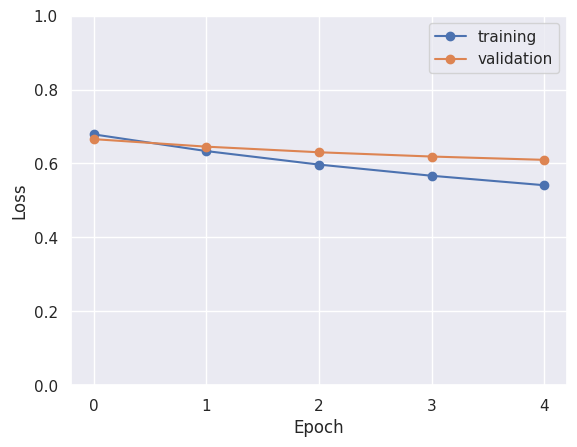

In [ ]:
model1 = build_onehot_model()

# Fit the model.
history1 = model1.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model1.summary()
# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history1 = pd.DataFrame(history1.history)
plot_history(history1)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5549 - loss: 0.6921 - val_accuracy: 0.6416 - val_loss: 0.6887
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6682 - loss: 0.6869 - val_accuracy: 0.6712 - val_loss: 0.6841
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6859 - loss: 0.6820 - val_accuracy: 0.6784 - val_loss: 0.6796
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6948 - loss: 0.6773 - val_accuracy: 0.6836 - val_loss: 0.6754
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6984 - loss: 0.6727 - val_accuracy: 0.6892 - val_loss: 0.6713


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ global_average_pooling1d             │ (None, 1000)                │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,005 (11.74 KB)

 Trainable params: 1,001 (3.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,004 (7.83 KB)

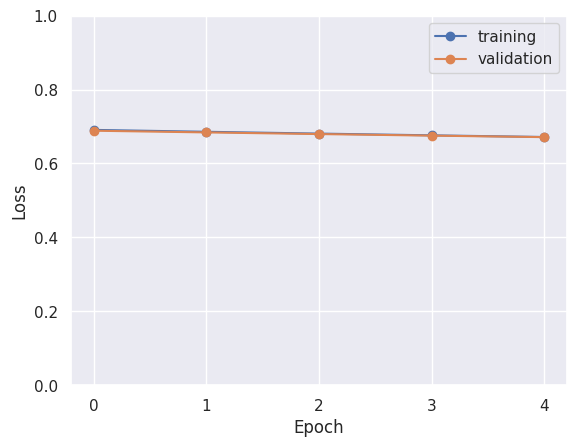

In [ ]:
lra_model = build_onehot_model(average_over_positions = True)

# Fit the model.
history_lra = lra_model.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

lra_model.summary()
# Convert the return value into a DataFrame so we can see the train loss
# and binary accuracy after every epoch.
history_lra = pd.DataFrame(history_lra.history)
plot_history(history_lra)


* The final training and validation accuracies for LR-C are: .8108 and .6836 respectively. The final training and validation accuracies for LR-A are .6984 and .6892 respectively.
* There are 20,001 trainable parameters and 60,005 ttotal parameters for the LR-C model. There are 1,001 trainable parameters and 3,005 total parameters for the LR-A model
* Between the two models, the LR-C model exhibits more overfitting with a .1272 difference between the train and validation accuracies. Further, upon visual inspection, the training loss continues to trend downward relatively quickly across epochs, whereas the validation is much more modest in its loss optimization. In contrast, the training and validaiton accuracies for the LR-A model are extremely similar, demonstrating no overfitting behavior and meaning that the model will likely perform similarly for new unseen data.
* The LR-C approach treats tokens as separate features and does not average over partitions. The LR-A model takes the averaes of token positions. This averaging approach yields significantly less trainable parameters for the LR-A model which likely reduces the chance of overfitting to the training data. On the other hand, the LR-C model treats 20,000 parameters and a bias inidividually when training. This allows the LR-C model to find patterns very specific to the training data and is likely a main factor in the overfitting behavior of the LR-C model.


### <span style="color:chocolate">Comparison Model: Logistic Regression with Embeddings</span>

In [ ]:
def build_embeddings_model(average_over_positions=False,
                           vocab_size=1000,
                           sequence_length=20,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())

  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

  return model

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5741 - loss: 0.6900 - val_accuracy: 0.6624 - val_loss: 0.6766
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6824 - loss: 0.6688 - val_accuracy: 0.6884 - val_loss: 0.6505
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6998 - loss: 0.6397 - val_accuracy: 0.7012 - val_loss: 0.6239
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7112 - loss: 0.6110 - val_accuracy: 0.7076 - val_loss: 0.6016
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7180 - loss: 0.5868 - val_accuracy: 0.7128 - val_loss: 0.5844


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 2)               │           2,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 2)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,011 (23.48 KB)

 Trainable params: 2,003 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,008 (15.66 KB)

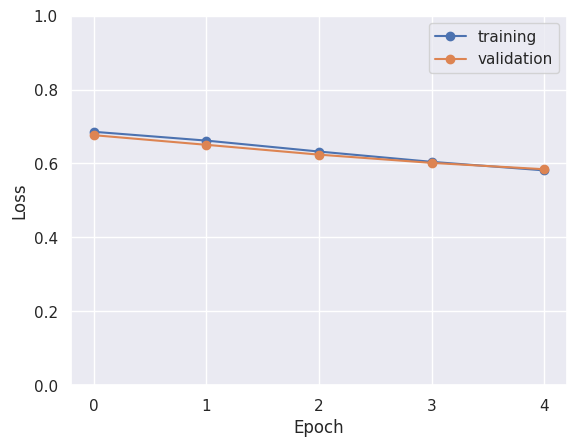

In [ ]:
model2 = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=2)
history2 = model2.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model2.summary()

history2 = pd.DataFrame(history2.history)
plot_history(history2)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5975 - loss: 0.6876 - val_accuracy: 0.6680 - val_loss: 0.6663
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6889 - loss: 0.6537 - val_accuracy: 0.6936 - val_loss: 0.6280
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7100 - loss: 0.6122 - val_accuracy: 0.7052 - val_loss: 0.5965
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7216 - loss: 0.5787 - val_accuracy: 0.7176 - val_loss: 0.5751
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7284 - loss: 0.5549 - val_accuracy: 0.7208 - val_loss: 0.5611


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 4)               │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 4)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,017 (46.95 KB)

 Trainable params: 4,005 (15.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,012 (31.30 KB)

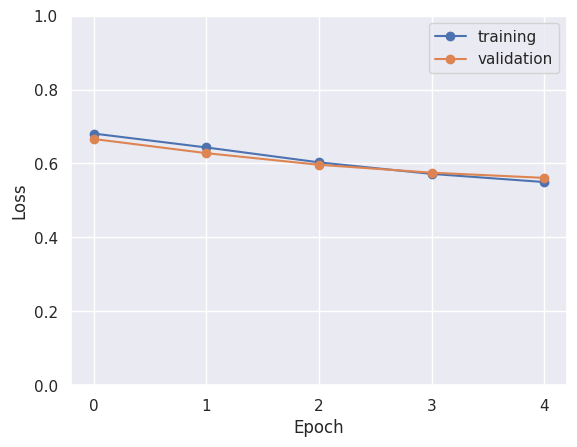

In [ ]:
model3 = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=4)
history3 = model3.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model3.summary()

history3 = pd.DataFrame(history3.history)
plot_history(history3)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5977 - loss: 0.6860 - val_accuracy: 0.6692 - val_loss: 0.6542
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6966 - loss: 0.6358 - val_accuracy: 0.6964 - val_loss: 0.6034
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7175 - loss: 0.5833 - val_accuracy: 0.7184 - val_loss: 0.5721
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7301 - loss: 0.5498 - val_accuracy: 0.7188 - val_loss: 0.5552
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7421 - loss: 0.5297 - val_accuracy: 0.7240 - val_loss: 0.5459


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 8)               │           8,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,029 (93.87 KB)

 Trainable params: 8,009 (31.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,020 (62.58 KB)

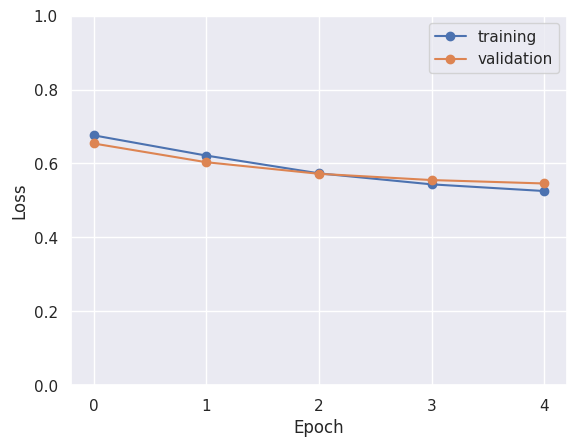

In [ ]:
model4 = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=8)
history4 = model4.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model4.summary()

history4 = pd.DataFrame(history4.history)
plot_history(history4)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6031 - loss: 0.6816 - val_accuracy: 0.6756 - val_loss: 0.6327
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7077 - loss: 0.6080 - val_accuracy: 0.7160 - val_loss: 0.5761
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7301 - loss: 0.5524 - val_accuracy: 0.7204 - val_loss: 0.5520
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7438 - loss: 0.5253 - val_accuracy: 0.7236 - val_loss: 0.5420
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7510 - loss: 0.5113 - val_accuracy: 0.7300 - val_loss: 0.5379


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 16)              │          16,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 16)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,053 (187.71 KB)

 Trainable params: 16,017 (62.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 32,036 (125.14 KB)

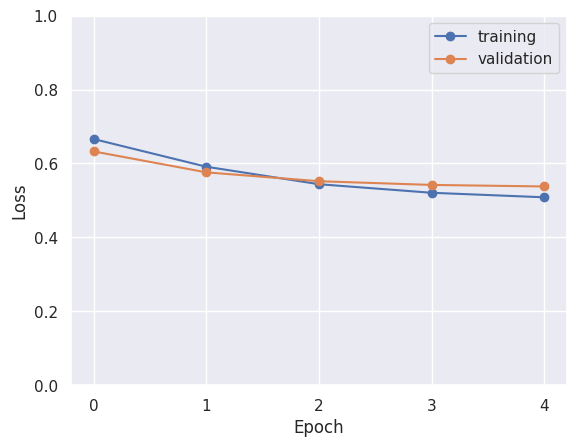

In [ ]:
model5 = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=16)
history5 = model5.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model5.summary()

history5 = pd.DataFrame(history5.history)
plot_history(history5)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6084 - loss: 0.6773 - val_accuracy: 0.6948 - val_loss: 0.6081
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7152 - loss: 0.5803 - val_accuracy: 0.7212 - val_loss: 0.5557
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7403 - loss: 0.5298 - val_accuracy: 0.7296 - val_loss: 0.5409
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7498 - loss: 0.5105 - val_accuracy: 0.7312 - val_loss: 0.5366
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7552 - loss: 0.5017 - val_accuracy: 0.7292 - val_loss: 0.5358


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 32)              │          32,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,101 (375.40 KB)

 Trainable params: 32,033 (125.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 64,068 (250.27 KB)

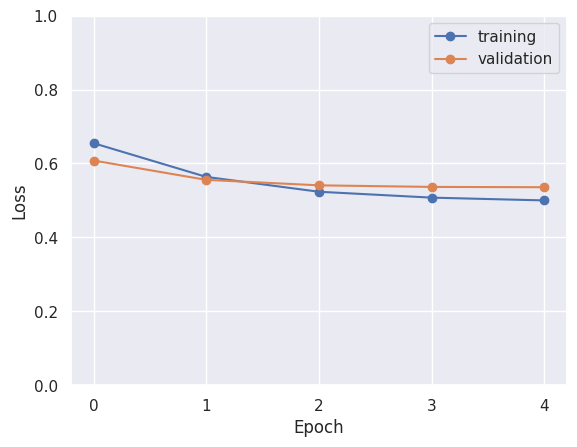

In [ ]:
model6 = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=32)
history6 = model6.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model6.summary()

history6 = pd.DataFrame(history6.history)
plot_history(history6)

Epoch 1/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6110 - loss: 0.6691 - val_accuracy: 0.7092 - val_loss: 0.5800
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7282 - loss: 0.5519 - val_accuracy: 0.7196 - val_loss: 0.5427
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7479 - loss: 0.5143 - val_accuracy: 0.7292 - val_loss: 0.5360
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7545 - loss: 0.5024 - val_accuracy: 0.7308 - val_loss: 0.5354
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7577 - loss: 0.4974 - val_accuracy: 0.7304 - val_loss: 0.5363


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 64)              │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 192,197 (750.77 KB)

 Trainable params: 64,065 (250.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 128,132 (500.52 KB)

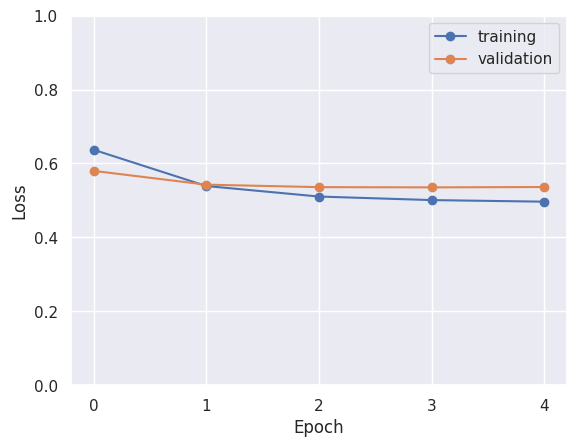

In [ ]:
model7 = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=64)
history7 = model7.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

model7.summary()

history7 = pd.DataFrame(history7.history)
plot_history(history7)

### <span style="color:chocolate">Results of Embedding Size Tuning</span>

Embedding Size | Training Accuracy | Validation Accuracy | Trainable Parameters
- | - | - | -
2 | .7180 | .6624 | 2003
4 | .7284 | .7208 | 4005
8 | .7421 | .7240 | 8009
16 | .7510 | .7300 | 16017
32 | .7552 | .7292 | 32033
64 | .7577 | .7304 | 64065

Using the learned embeddings approach improves performance in comparison to one-hot encoding. This is because learned embeddings capture the context of words, finding groups of commonly used together words, while also reducing the number of trainable parameters. In contrast, one-hot encoding treats words on their own. Using learned embeddings not only reduces the risk of overffiting, but is also more space efficient as one-hot encodings take up much space.


---

### Inspecting Learned Embeddings

In [ ]:
# Display the model layers.
display(model2.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings2 = model2.layers[0].get_weights()[0]
display(embeddings2.shape)

[<Embedding name=embedding, built=True>,
 <GlobalAveragePooling1D name=global_average_pooling1d, built=True>,
 <Dense name=dense, built=True>]

(1000, 2)

In [ ]:
def plot_2d_embeddings(embeddings, id_start=1, count=100):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]

  # Get the corresponding words from the reverse index (for labeling).
  tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.
plot_2d_embeddings(embeddings2, id_start=500, count=500)

### <span style="color:chocolate">Interpreting Embeddings</span>

* The learned embeddings somewhat separate positive and negative words by placing them on a spectrum based on their context. The most negative word is 'avoid'. This makes sense not only because 'avoid' is a typically negative word, but also because there are a smaller number of ways to use 'avoid' in a positive review. For example, "This is something you won't want to avoid" is not the way a typical English speaker would write a positive review.
* "Save" is found towards the most negative word spectrum, which on initial view was surprising. However, upon further inspection, 'save' is often used in 'save yourself the time', explaining it's negative position. "Today" was also somewhat suprising, as a seemingly neutral word that lended itself to the positive side. This leads me to believe that reviews that were written on the day of viewing (e.g., "Today I saw XX and it was amazing!) were more positive than those written at another time. 7, 8, and, 9 were also found on the positive end as they were likely found in combination with other positive words. Perhaps these reviews include ratings such as "8/10 stars, overall a great movie!"
* An embedding at (0,0) indicates a neutral word that appeared in both positive and negative context. Crazy was seen in both positive and negative reviews, as it can be used in multiple contexts. Examples include "That movie was crazy good!" or "You would be crazy to drop $20 on that movie - abismal."
* The embedding dimensions appear to indicate numeric scales that allow us to map words based on contextual similaries. In this case, the axes have an inverse relationship, where highly positive words trend toward the positive Y-axis and negative X-axis. Inversely, negative words are found on the spectrum towards a negative Y-axis and positive X-axis.
